In [1]:
include("src/sqmodule.jl")
include("src/common.jl")
import .SQmodule 
import .Common
using NPZ # For loading data
using Statistics

In [2]:
abstract type Memory_Task end

struct STM_Task <: Memory_Task
    name:: String
    τ::Int64
    p::Int64
    function STM_Task(τ)
        new("STM",τ,1)
    end
end

function testing_system(u::Matrix{Float64},metric::Common.Metric,Nwtr::Int64,washout::Int64,Ntest::Int64,type::Symbol,hyparam,task::Memory_Task)
    error_ = Vector{Float64}(undef,length(hyparam))
    yin = Memory_target(u,τ,Ntest+Nwtr,task)
    for j=1:length(hyparam)
        tupla = hyparam[j]
        model = SQmodule.build_SQModel(tupla,type) 
        weights, ρ0 = SQmodule.train(model,u[τ+1:Nwtr+τ,:],yin[τ+1:Nwtr+τ,:],Nwtr,washout)
        ytest = SQmodule.pred_openloop(model,u[Nwtr+τ+1:Nwtr+Ntest+τ,:],weights,ρ0,Ntest)
        error_[j] = Common.metric_val(metric,yin[Nwtr+τ+1:Nwtr+Ntest+τ,:],ytest)
    end
    return error_
end

function Memory_target(u,τ,N,task::STM_Task)
    y = zeros(Float64,N+τ)
    y[τ+1:N+τ] = u[1:N]
    return y
end

function logrange(x1, x2, n)
    return 10 .^ range(x1, stop=x2, length=n)
end

function build_hyparam(allhyparam::Tuple{Vararg{Vector{Float64}}})
    return collect(Iterators.product(allhyparam...))
end


build_hyparam (generic function with 1 method)

In [3]:
τ = 1
task = STM_Task(τ)
washout = 100
Ntrain = 1000
Ntest = 1000
Nwtr = Ntrain+washout
Ntotal = Ntest+Nwtr+τ

n_lines = 4 # number of lines in the plot
g_points = 100 # number of points in the plot
g_ = collect(logrange(-2,2,g_points)) #Input strength
ϵ_ = collect(range(0.2,0.8,n_lines)) #Leaking rate
λ_ = [1e-10] #Regularization parameter
allhyparam = (g_,ϵ_,λ_)
hyparam = build_hyparam(allhyparam)
type = :Example24 #QRC model
metric = Common.Metric_C(); #metric of the validation!

realizations = 100 # number of random realizations of the input sequence

error_list = Matrix{Float64}(undef,length(hyparam),realizations) 
for r=1:realizations
    u = rand(Ntotal,1)
    error_list[:,r] = testing_system(u,metric,Nwtr,washout,Ntest,type,hyparam,task)
end
mean_list = mean(error_list,dims=2)
std_list = std(error_list,dims=2);

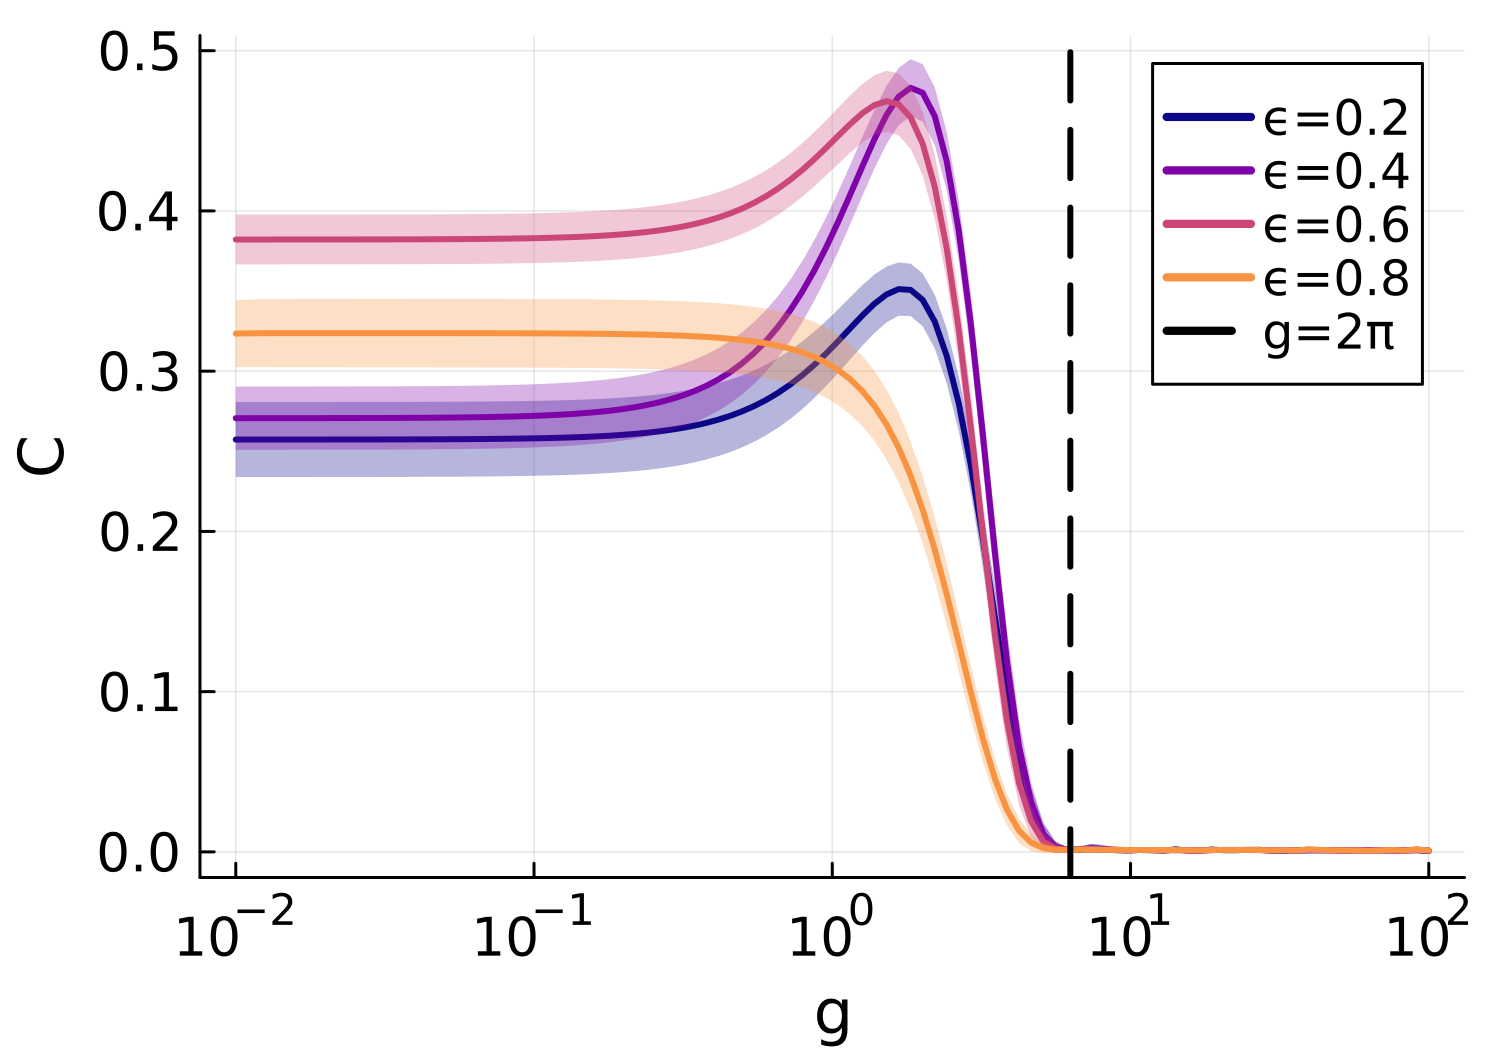

"/home/rodrigo/Escritorio/Donostia/postdoc/Resultados/QRC2/input-dependence-QRC/Fig2.png"

In [4]:
using Plots
colors=palette(:plasma, n_lines+1) # You can also try :viridis, etc.
# Initialize plot
p = plot(xscale = :log10,tickfontsize = 12, size=(500,350),
legendfontsize = 11,guidefontsize = 14,dpi=300)

for i in 1:n_lines
    m = mean_list[1+(i-1)*g_points:i*g_points]
    s = std_list[1+(i-1)*g_points:i*g_points]
    c = colors[i]
    # Shaded region
    plot!(g_, m .+ s, fillrange=m .- s, fillalpha=0.3, linealpha=0, color=c, label="")
    # Mean line
    plot!(g_, m, color=c, lw=2, label="ϵ=$(ϵ_[i])")
end
# Add vertical line at x=2π
vline!([2*π], color = :black, linestyle = :dash, linewidth = 2, label = "g=2π")
# Final touches
xlabel!("g")
ylabel!("C")
display(p)
savefig(p,"Fig2.png")